In [1]:
!pip install ipywidgets > /dev/null
!jupyter nbextension enable --py widgetsnbextension

import os
from tqdm import tqdm
from IPython.display import Image, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
# from anacinx_misc import *
%run -i anacinx_misc.py

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
def create_instance(home_dir, image_path):
    #!apptainer instance start -H /home/bbogale/results/ dir_anacinx/ anacin
    cmd = 'apptainer instance start -H {} {} anacin_jupyter_instance'.format(home_dir, image_path)
    #!apptainer instance start -H home_dir image_path instance_name
    !{cmd}

In [6]:
create_instance("/home/bbogale/results", "/home/bbogale/dir_anacinx")

INFO:    instance started successfully


In [3]:
def kill_instance():
    !apptainer instance stop anacin_jupyter_instance

In [5]:
kill_instance()

INFO:    Stopping anacin_jupyter_instance instance of /home/bbogale/dir_anacinx (PID=71978)


In [27]:
def clean_output_dir(output_dir):
    #implement error checking
    os.system("rm -rf {}/*".format(output_dir))

In [28]:
def trace_execution(executable_path, args, num_processes, num_runs, num_iterations, pnmpi_conf, output_dir):

    
    #For benchmark
    #Add functionality to choose message type
#     !apptainer exec instance://anacin_jupyter_instance \
#     python3 /ANACIN-X/apps/comm_pattern_generator/config/json_gen.py \
#     "naive_reduce" 512 5 "/home/bbogale/results/" 0.0 0.1 1.0
    !apptainer exec instance://anacin_jupyter_instance \
    python3 /ANACIN-X/apps/comm_pattern_generator/config/json_gen.py \
    "naive_reduce" 512 {num_iterations} "/home/bbogale/results/" 0.0 0.1 1.0
    
    !apptainer exec instance://anacin_jupyter_instance cp  /ANACIN-X/submodules/CSMPI/config/default_glibc.json {output_dir}
    
    for i in tqdm(range(0,int(num_runs))):
        #Create run directory
        run_dir = "{}/run_{}/".format(output_dir, str(i).rjust(3, "0"))
        !mkdir {run_dir}
        
        #Copy CSMPI config file to run directories
        !cp {output_dir}/default_glibc.json {run_dir}/

        !sed -i 's|null|'{run_dir}'|g' {run_dir}/default_glibc.json
        
        !cd {run_dir} ; mpirun -np {num_processes} apptainer exec \
        --env LD_PRELOAD=/ANACIN-X/submodules/PnMPI/build/lib/libpnmpi.so \
        --env PNMPI_LIB_PATH=/ANACIN-X/anacin-x/pnmpi/patched_libs \
        --env PNMPI_CONF=/ANACIN-X/anacin-x/pnmpi/configs/{pnmpi_conf} \
        --env CSMPI_CONFIG={run_dir}/default_glibc.json \
        instance://anacin_jupyter_instance {executable_path} {args} > /dev/null
        
   
    #Delete CSMPI conf from output dir
    !rm {output_dir}/default_glibc.json

In [29]:
def generate_event_graph(num_processess, num_runs, dumpi_config,  output_dir):
    #Come back to this later and add config selection functionality
    dumpi_to_graph_bin="/ANACIN-X/submodules/dumpi_to_graph/build/dumpi_to_graph"
    #dumpi_to_graph_config="/ANACIN-X/submodules/dumpi_to_graph/config/" + {dumpi_config}
    dumpi_to_graph_config="/ANACIN-X/submodules/dumpi_to_graph/config/"

    #dumpi_to_graph_config="/ANACIN-X/submodules/dumpi_to_graph/config/dumpi_and_csmpi.json"

    
    for i in tqdm(range(0, num_runs)):
        run_dir = "{}/run_{}/".format(output_dir, str(i).rjust(3, "0"))
        !cd {run_dir} ; \
        mpirun -np {num_processess} apptainer exec instance://anacin_jupyter_instance {dumpi_to_graph_bin} {dumpi_to_graph_config}{dumpi_config} {run_dir} > /dev/null
    
    #!mpirun -np {num_processess} {dumpi_to_graph_bin} {dumpi_to_graph_config} {run_dir}

In [30]:
def extract_slices(num_processess, num_runs, slicing_policy_config, output_dir):
    #Add functionality to select custom slicing policies
    #slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/barrier_delimited_full.json"
    #slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/" + {slicing_policy_config}
    slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/"

    
    for i in tqdm(range(0, num_runs)):
        run_dir = "{}/run_{}/".format(output_dir, str(i).rjust(3, "0"))
        !cd {run_dir} ; mpirun -np {num_processess} \
        apptainer exec instance://anacin_jupyter_instance \
        /ANACIN-X/anacin-x/event_graph_analysis/extract_slices.py {run_dir}/"event_graph.graphml" {slicing_policy}{slicing_policy_config} -o "slices" > /dev/null

In [31]:
def compute_kdts(num_processess, slicing_policy_config, output_dir):
    #Consult Jack about this
    graph_kernel_policy = "/ANACIN-X/anacin-x/event_graph_analysis/graph_kernel_policies/wlst_5iters_logical_timestamp_label.json"
    #slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/barrier_delimited_full.json"
    slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/"
    
    !cd {output_dir} ; \
    mpirun -np {num_processess} apptainer exec instance://anacin_jupyter_instance \
    /ANACIN-X/anacin-x/event_graph_analysis/compute_kernel_distance_time_series.py \
    {output_dir} {graph_kernel_policy} --slicing_policy {slicing_policy}{slicing_policy_config} -o "kdts.pkl" --slice_dir_name {output_dir}/"slices" -c > /dev/null

In [32]:
# def create_graph(output_dir):
#Remove hard coded paths here ---TODO---
def create_graph():
    !apptainer exec instance://anacin_jupyter_instance \
    bash -c 'cd /ANACIN-X ; python3 anacin-x/event_graph_analysis/visualization/make_message_nd_plot.py \
    /home/bbogale/results/kdts.pkl \
    message_race \
    anacin-x/event_graph_analysis/graph_kernel_policies/wlst_5iters_logical_timestamp_label.json \
    /home/bbogale/results/kdts \
    0.0 0.1 1.0'
    
    
    

### Demonstration
- We will follow each step of the execution process:
    1. Trace execution
    2. Event graph generation
    3. Slice extraction
    2. Visualization

In [34]:
print(param_num_processes)
print(param_num_runs)
print(param_num_iterations)
print(param_pnmpi_config)
print(param_executable)
print(param_executable_args)

30
5
5
dumpi_pluto_csmpi.conf




### Raw Executation

In [15]:
clean_output_dir("/home/bbogale/results/")

In [19]:
trace_execution("/ANACIN-X/apps/comm_pattern_generator/build/comm_pattern_generator", "/home/bbogale/results/message_race_msg_size_512_niters_5_ndp_0.0_0.1_1.0.json /ANACIN-X/anacin-x/config", 30, 10, 5, "dumpi_pluto_csmpi.conf", "/home/bbogale/results")

100%|████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.99s/it]


In [20]:
generate_event_graph(30, 10, "dumpi_and_csmpi.json", "/home/bbogale/results/")

100%|████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.69s/it]


In [21]:
extract_slices(30, 10,  "barrier_delimited_full.json", "/home/bbogale/results/")

100%|████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.53s/it]


In [22]:
compute_kdts(30, "barrier_delimited_full.json", "/home/bbogale/results/")

In [70]:
!apptainer exec instance://anacin_jupyter_instance \
bash -c 'cd /ANACIN-X ; python3 anacin-x/event_graph_analysis/visualization/make_message_nd_plot.py \
/home/bbogale/results/kdts.pkl \
message_race \
anacin-x/event_graph_analysis/graph_kernel_policies/wlst_5iters_logical_timestamp_label.json \
/home/bbogale/results/kdts \
0.0 0.1 1.0'

Your Pearson's r value     = 0.5

It's corresponding p value = 1.1603165014108233e-32



Your Spearman's ρ value    = 0.5

It's corresponding p value = 1.4582369623774334e-32



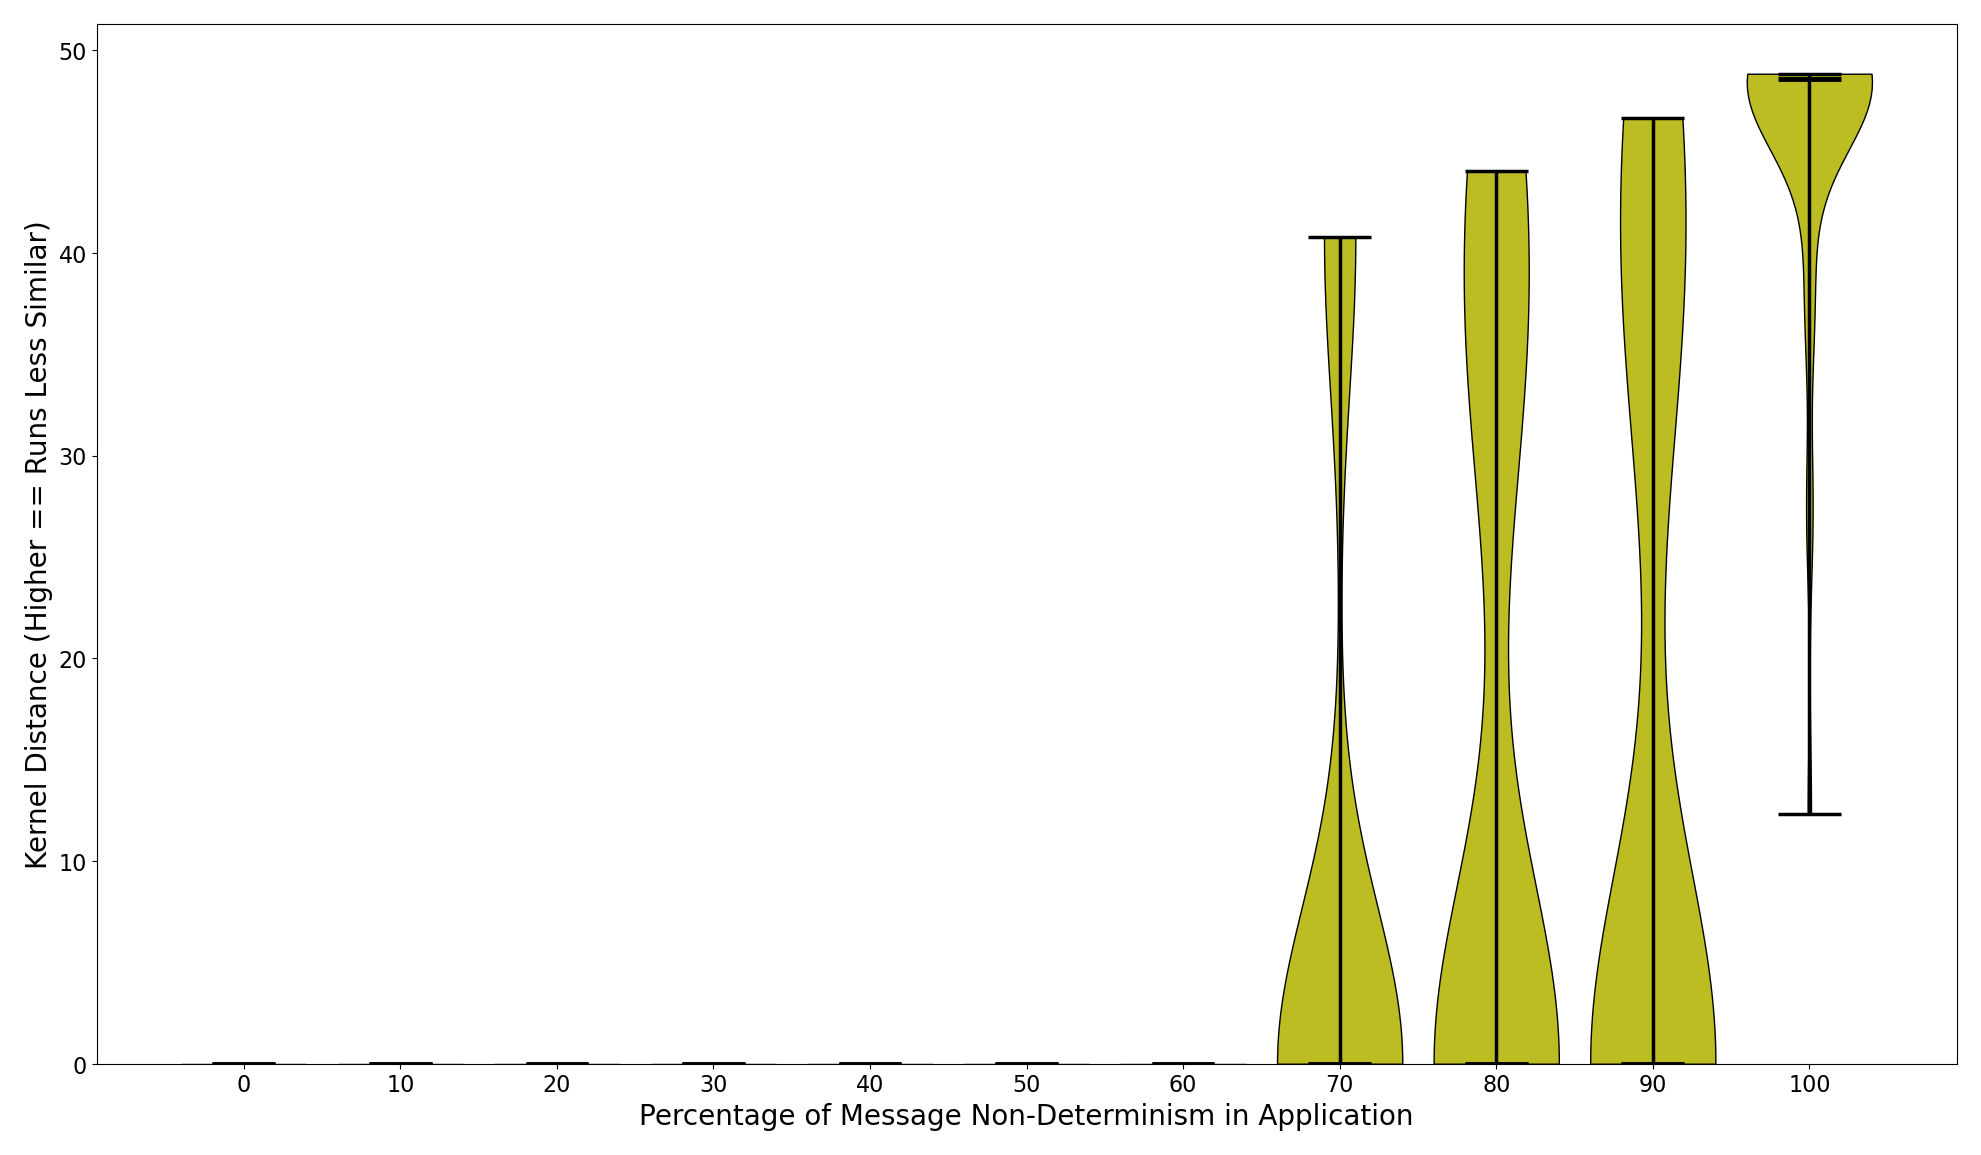

In [70]:
Image(filename="/home/bbogale/results//kdts.png")

### Widget Based Execution

In [33]:
display(widgets.HBox([benchmark_type_selector_widget, extern_type_selector_widget]))

IntText(value=0, description='Number of processess:', layout=Layout(width='50%'), style=DescriptionStyle(descr…

IntText(value=0, description='Number of runs:', layout=Layout(width='50%'), style=DescriptionStyle(description…

IntText(value=0, description='Number of iterations:', layout=Layout(width='50%'), style=DescriptionStyle(descr…

Dropdown(description='PnMPI Config:', layout=Layout(width='50%'), options=(('', ''), ('csmpi', 'csmpi.conf'), …

### Execution

In [35]:
display(trace_widget)

Button(description='Trace', layout=Layout(width='50%'), style=ButtonStyle())

Tracing...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.90s/it]


In [41]:
display(gen_event_graph_widget)

Button(description='Generate Event Graph', layout=Layout(width='50%'), style=ButtonStyle())

Generating Event Graph...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.69s/it]


In [37]:
display(slice_extraction_widget)

Button(description='Extract Slices', layout=Layout(width='50%'), style=ButtonStyle())

Extracting Slices...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.99s/it]


In [38]:
display(compute_kdts_widget)

Button(description='Compute KDTS', layout=Layout(width='50%'), style=ButtonStyle())

Computing the KDTS...
Done!


In [39]:
display(create_visualization_widget)

Button(description='Create Visualization', layout=Layout(width='50%'), style=ButtonStyle())

Creating Visualization...
Your Pearson's r value     = 0.56

It's corresponding p value = 3.012206056179359e-10



Your Spearman's ρ value    = 0.57

It's corresponding p value = 7.983327875062835e-11



### Visualization

Button(description='Display Visualization', layout=Layout(width='50%'), style=ButtonStyle())

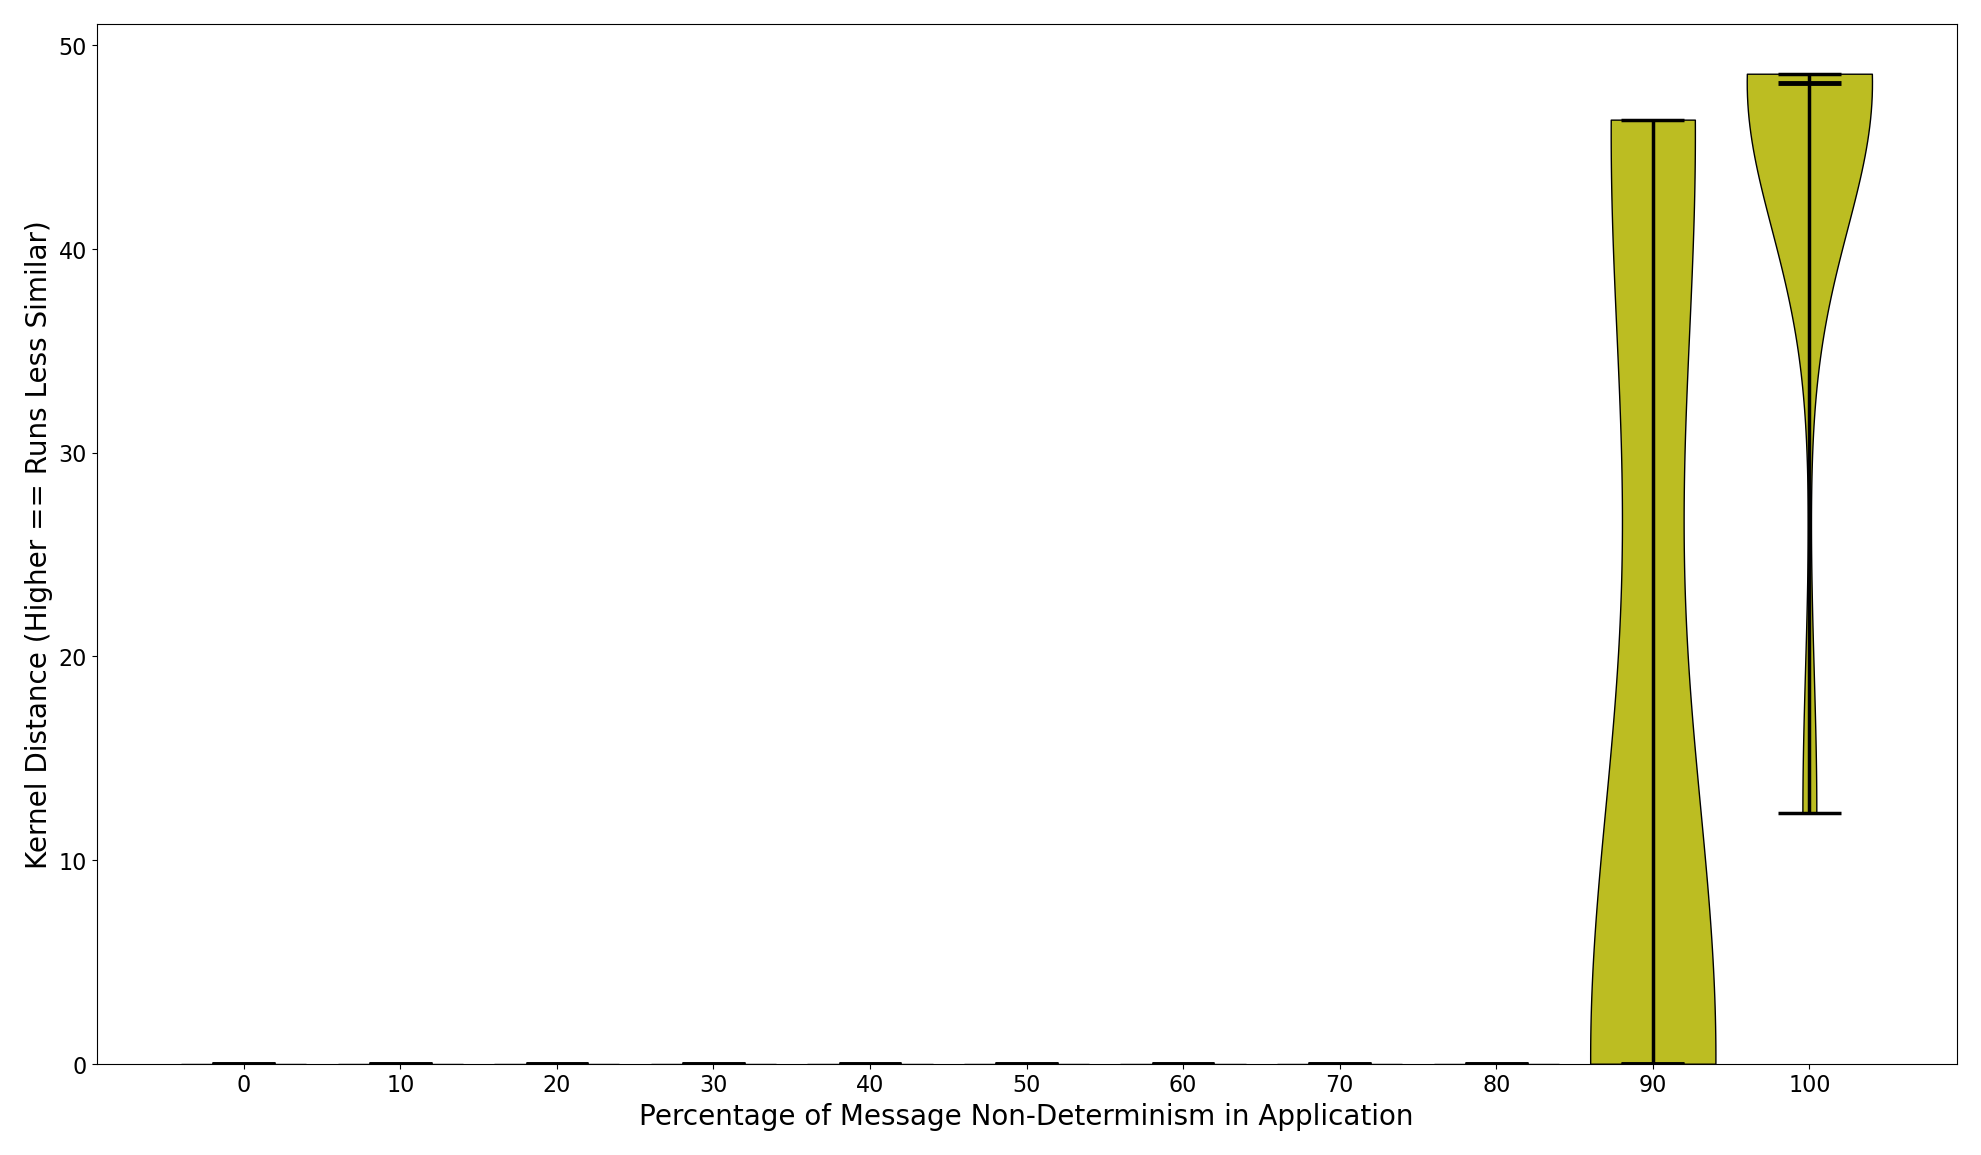

In [40]:
display(display_visualization_widget)